In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
print(f"Old working dir {os.getcwd()}")
os.chdir('../')
print(f"New working dir {os.getcwd()}")

Old working dir /Users/vladimir.kondratyev/conditional_quantile_function/poc
New working dir /Users/vladimir.kondratyev/conditional_quantile_function


In [3]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


In [4]:
from scipy.stats import norm, multivariate_normal

In [5]:
def _make_xy_dataloader(X: np.ndarray, Y: np.ndarray, batch_size: int, dtype=torch.float64) -> DataLoader:
    dataset = TensorDataset(torch.tensor(X, dtype=dtype), torch.tensor(Y, dtype=dtype))
    dataloader = DataLoader(dataset, batch_size=batch_size)
    return dataloader


In [6]:
from infrastructure.classes import TrainParameters
from pushforward_operators import NeuralQuantileRegression, AmortizedNeuralQuantileRegression


class OurCVQRegressor:

    def __init__(
        self,
        feature_dimension: int,
        response_dimension: int,
        hidden_dimension: int,
        number_of_hidden_layers: int,
        batch_size: int,
        n_epochs: int,
        learning_rate: float = 0.01,
        dtype=torch.float64,
    ):
        self.feature_dimension: int = feature_dimension
        self.response_dimension: int = response_dimension
        self.hidden_dimension: int = hidden_dimension
        self.number_of_hidden_layers: int = number_of_hidden_layers
        self.batch_size: int = batch_size
        self.n_epochs: int = n_epochs
        self.learning_rate: float = learning_rate
        self.dtype = dtype
        self.model = AmortizedNeuralQuantileRegression(
            feature_dimension=self.feature_dimension,
            response_dimension=self.response_dimension,
            hidden_dimension=self.hidden_dimension,
            number_of_hidden_layers=self.number_of_hidden_layers,
            potential_to_estimate_with_neural_network="y",
        ).to(self.dtype)

    def fit(self, X: np.ndarray, Y:np.ndarray):
        dataloader = _make_xy_dataloader(X, Y, batch_size=self.batch_size, dtype=self.dtype)
        train_parameters = TrainParameters(number_of_epochs_to_train=self.n_epochs, 
                                           optimizer_parameters=dict(lr=self.learning_rate),
                                           scheduler_parameters={"eta_min": 0.},
                                           verbose=True)
        self.model.fit(dataloader, train_parameters=train_parameters,)

    def predict_mean(self, X):
        n = X.shape[0]
        U = torch.zeros((n, self.response_dimension), dtype=self.dtype)
        X_tensor = torch.tensor(X, dtype=self.dtype)
        #dataset = TensorDataset(X_tensor, U)
        #dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        Y = self.model.push_u_given_x(x=X_tensor, u=U)
        return Y.numpy(force=True)
    
    def predict_quantile(self, X, Y):
        return self.model.push_y_given_x(y=torch.tensor(Y), 
                                         x=torch.tensor(X)).numpy(force=True)


In [7]:
from conformal.real_datasets.reproducible_split import get_dataset_split, DatasetSplit
from utils.network import get_total_number_of_parameters

In [8]:
seed = 0
dataset_name = "scm1d"
dataset_name = "rf1"

ds = get_dataset_split(name=dataset_name, seed=seed, n_train=5125)
ds.Y_train = ds.Y_train[:, :4]
ds.Y_test = ds.Y_test[:, :4]
ds.Y_cal = ds.Y_cal[:, :4]

ds.X_train = ds.X_train[:, :16] 
ds.X_test = ds.X_test[:, :16] 
ds.X_cal = ds.X_cal[:, :16] 

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from metrics.wsc import wsc_unbiased

## Algorithms according to section 5

In [10]:
alpha = 0.3

In [11]:
from IPython.display import display, Markdown

### Part 1: Train base model $\tilde{Q}_{Y|X}^{-1}(X, Y)$ on train set

In [12]:
reg = OurCVQRegressor(
    feature_dimension=16,
    response_dimension=4,
    hidden_dimension=8,
    number_of_hidden_layers=2,
    batch_size=1024,
    n_epochs=1000,
)

print(f"Number of parameters: {get_total_number_of_parameters(reg.model.potential_network)}, number of training samples: {ds.n_train}.")

Number of parameters: 1238, number of training samples: 5125.


In [14]:
model_savepath = f"test_neural_optimal_trasnsport.pth"
if not os.path.isfile(model_savepath):
    reg.fit(ds.X_train, ds.Y_train)
    reg.model.save(model_savepath)
    reg.model.eval()
else:
    reg.model.load(model_savepath)
    reg.model.eval()

Epoch: 1000, Potential Objective: 0.420, Amortization Objective: 0.230, LR: 0.010000: 100%|██████████| 1000/1000 [20:07<00:00,  1.21s/it]


In [15]:
quantiles_cal = reg.predict_quantile(ds.X_cal, ds.Y_cal)
quantiles_test = reg.predict_quantile(ds.X_test, ds.Y_test)

Diagnstic plots for quantiles

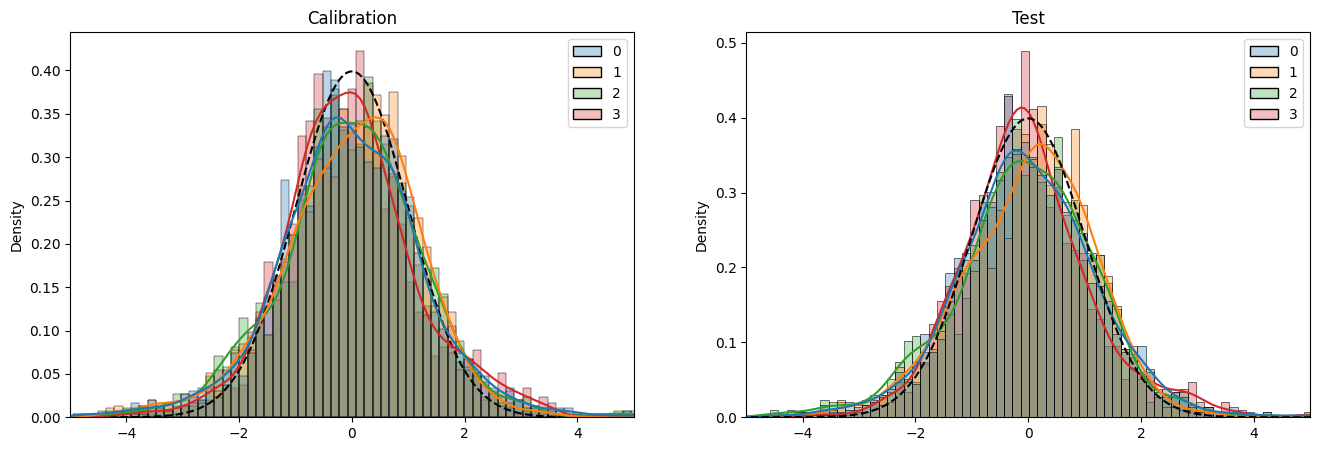

In [16]:
from scipy.stats import expon

t_min = min(quantiles_cal.min(), quantiles_test.min())
t_max = max(quantiles_cal.max(), quantiles_test.max())
t = np.linspace(t_min, t_max, 500)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
p0 = ax[0].plot(t, norm.pdf(t), 'k--', label="N(0, 1)")
hp0 = sns.histplot(quantiles_cal, alpha=0.3, stat="density", common_norm=False, kde=True, ax=ax[0])
ax[0].set_title("Calibration")
ax[0].set_xlim(-5, 5)
hp1 = sns.histplot(quantiles_test, alpha=0.3, stat="density", common_norm=False, kde=True, ax=ax[1])
p1 = ax[1].plot(t, norm.pdf(t), 'k--', label="N(0, 1)")
ax[1].set_title("Test")
ax[1].set_xlim(-5, 5)

plt.show()

In [17]:
from scipy import stats


def draw_qq_scores(scores, ax):
    n, d = scores.shape
    for j in range(d):
        stats.probplot(
            scores[:, j],
            dist="norm",
            fit=False,
            plot=ax,
        )
        ax.get_lines()[j].set_markerfacecolor(f'C{j}')
        ax.get_lines()[j].set_markeredgecolor(f'C{j}')
    ax.plot([-3, 3], [-3, 3], ls='--', c='k')


Text(0.5, 1.0, 'Test')

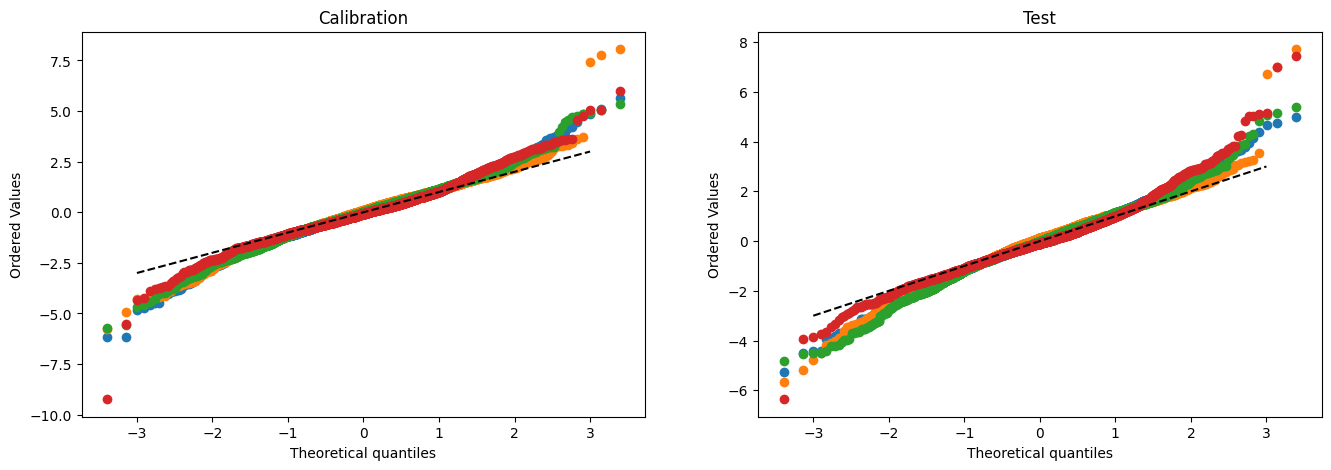

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
draw_qq_scores(quantiles_cal, ax[0])
ax[0].set_title("Calibration")
draw_qq_scores(quantiles_test, ax[1])
ax[1].set_title("Test")

### Part 2: Implement Method 5.1a (only marginal calibration)

Scores $S_i = || \tilde{Q}_{Y|X}^{-1}(X_i, Y_i) ||$, for $(X_i, Y_i) \in \mathcal{D}_{\mathrm{cal}}$

In [19]:
scores_cal_51a = np.linalg.norm(quantiles_cal, axis=1)
scores_test_51a = np.linalg.norm(quantiles_test, axis=1)

threshold_51a = np.quantile(scores_cal_51a, q=(ds.n_cal + 1) * (1 - alpha) / ds.n_cal)

In [20]:
is_covered_51a = scores_test_51a <= threshold_51a

for rs in range(10):
    cov_51a = is_covered_51a.mean()
    wsc_51a = wsc_unbiased(ds.X_test, is_covered_51a, delta=0.1, M=10000, random_state=rs, n_cpus=8)
    display(
        Markdown(
            r"#### $\mathcal{C}_{\rho}^{\mathrm{pb}}$ Marginal coverage: " +
            f"**{cov_51a:.2f}**, " +
            f"worst-slab conditional coverage: **{wsc_51a:.2f}**"
        )
    )

#### $\mathcal{C}_{\rho}^{\mathrm{pb}}$ Marginal coverage: **0.73**, worst-slab conditional coverage: **0.58**

#### $\mathcal{C}_{\rho}^{\mathrm{pb}}$ Marginal coverage: **0.73**, worst-slab conditional coverage: **0.53**

#### $\mathcal{C}_{\rho}^{\mathrm{pb}}$ Marginal coverage: **0.73**, worst-slab conditional coverage: **0.58**

#### $\mathcal{C}_{\rho}^{\mathrm{pb}}$ Marginal coverage: **0.73**, worst-slab conditional coverage: **0.61**

#### $\mathcal{C}_{\rho}^{\mathrm{pb}}$ Marginal coverage: **0.73**, worst-slab conditional coverage: **0.53**

#### $\mathcal{C}_{\rho}^{\mathrm{pb}}$ Marginal coverage: **0.73**, worst-slab conditional coverage: **0.65**

#### $\mathcal{C}_{\rho}^{\mathrm{pb}}$ Marginal coverage: **0.73**, worst-slab conditional coverage: **0.61**

#### $\mathcal{C}_{\rho}^{\mathrm{pb}}$ Marginal coverage: **0.73**, worst-slab conditional coverage: **0.50**

#### $\mathcal{C}_{\rho}^{\mathrm{pb}}$ Marginal coverage: **0.73**, worst-slab conditional coverage: **0.59**

#### $\mathcal{C}_{\rho}^{\mathrm{pb}}$ Marginal coverage: **0.73**, worst-slab conditional coverage: **0.51**

### Part 3: Implement Method 5.1b (re-calibration)

Split calibration set in half and use static Monge-Cantorovich reranking.

In [23]:
# From official implementation of OT-CP paper
from conformal.otcp.functions_refactor import MultivQuantileTresholdRefactor, RankFuncRefactor


def _get_coverage_otcp(scores, mu, psi, q_hat, verbose=False):
    # Computing coverage on test set
    ConditionalRank = RankFuncRefactor(scores, mu, psi)
    rank_1d = np.linalg.norm(ConditionalRank, axis=1)
    if verbose:
        print(f"{len(np.unique(rank_1d))=}")
    is_covered_otcp = rank_1d <= q_hat
    return is_covered_otcp


def otcp_predict_coverage(scores_cal1, scores_cal2, scores_test, q=0.9, verbose=False):
    Quantile_Treshold, mu, psi, psi_star, data_calib = \
        MultivQuantileTresholdRefactor(scores_cal1, scores_cal2, alpha=q)

    # Computing coverage on test set
    is_covered_otcp = _get_coverage_otcp(scores_test, mu, psi, Quantile_Treshold, verbose=verbose)
    return is_covered_otcp, mu, psi, Quantile_Treshold

In [24]:
for rs in range(10):
    n1 = ds.n_cal // 2

    is_covered_51b, mu, psi, threshold_51b = otcp_predict_coverage(
        scores_cal1=quantiles_cal[:n1],
        scores_cal2=quantiles_cal[n1:],
        scores_test=quantiles_test,
        q=1 - alpha
    )

    cov_51b = is_covered_51b.mean()
    wsc_51b = wsc_unbiased(ds.X_test, is_covered_51b, delta=0.1, M=10000, random_state=rs, n_cpus=8, verbose=False)
    display(
        Markdown(
            r"#### $\mathcal{C}_{\rho}^{\mathrm{rpb}}$ Marginal coverage: " +
            f"**{cov_51b:.2f}**, " +
            f"worst-slab conditional coverage: **{wsc_51b:.2f}**"
        )
    )

#### $\mathcal{C}_{\rho}^{\mathrm{rpb}}$ Marginal coverage: **0.73**, worst-slab conditional coverage: **0.55**

#### $\mathcal{C}_{\rho}^{\mathrm{rpb}}$ Marginal coverage: **0.73**, worst-slab conditional coverage: **0.55**

#### $\mathcal{C}_{\rho}^{\mathrm{rpb}}$ Marginal coverage: **0.73**, worst-slab conditional coverage: **0.54**

#### $\mathcal{C}_{\rho}^{\mathrm{rpb}}$ Marginal coverage: **0.73**, worst-slab conditional coverage: **0.64**

#### $\mathcal{C}_{\rho}^{\mathrm{rpb}}$ Marginal coverage: **0.73**, worst-slab conditional coverage: **0.63**

#### $\mathcal{C}_{\rho}^{\mathrm{rpb}}$ Marginal coverage: **0.73**, worst-slab conditional coverage: **0.66**

#### $\mathcal{C}_{\rho}^{\mathrm{rpb}}$ Marginal coverage: **0.73**, worst-slab conditional coverage: **0.59**

#### $\mathcal{C}_{\rho}^{\mathrm{rpb}}$ Marginal coverage: **0.73**, worst-slab conditional coverage: **0.53**

#### $\mathcal{C}_{\rho}^{\mathrm{rpb}}$ Marginal coverage: **0.73**, worst-slab conditional coverage: **0.58**

#### $\mathcal{C}_{\rho}^{\mathrm{rpb}}$ Marginal coverage: **0.73**, worst-slab conditional coverage: **0.51**

To get good conditional coverage, reranking map has to be fitted on a large sample.

### Part 4: implement Method 5.2 HPD-based scores

In [25]:
from torch.func import hessian

In [26]:
compute_batch_hessian = torch.vmap(func=hessian(reg.model.potential_network, argnums=1), 
                                   in_dims=0, chunk_size=1024)

hessians_cal = compute_batch_hessian(torch.tensor(ds.X_cal), torch.tensor(ds.Y_cal)).squeeze()
hessians_test = compute_batch_hessian(torch.tensor(ds.X_test), torch.tensor(ds.Y_test)).squeeze()

In [27]:
logdet_hessians_cal = torch.logdet(hessians_cal).numpy(force=True)
logdet_hessians_test = torch.logdet(hessians_test).numpy(force=True)

In [28]:
log_f_u_cal = multivariate_normal.logpdf(quantiles_cal, mean=np.zeros(4))
log_f_u_test = multivariate_normal.logpdf(quantiles_test, mean=np.zeros(4))

In [29]:
scores_cal_52 = log_f_u_cal + logdet_hessians_cal
scores_test_52 = log_f_u_test + logdet_hessians_test

In [30]:
for rs in range(10):
    threshold_52 = np.quantile(scores_cal_52, q=(ds.n_cal + 1) * (alpha) / ds.n_cal)

    is_covered_52 = scores_test_52 >= threshold_52

    cov_52 = is_covered_52.mean()
    wsc_52 = wsc_unbiased(ds.X_test, is_covered_52, delta=0.1, M=10000, random_state=rs, n_cpus=8)

    display(
        Markdown(
            r"#### $\mathcal{C}_{\rho}^{\mathrm{HPD}}$ Marginal coverage: " +
            f"**{cov_52:.2f}**, " +
            f"worst-slab conditional coverage: **{wsc_52:.2f}**"
        )
    )

#### $\mathcal{C}_{\rho}^{\mathrm{HPD}}$ Marginal coverage: **0.71**, worst-slab conditional coverage: **0.43**

#### $\mathcal{C}_{\rho}^{\mathrm{HPD}}$ Marginal coverage: **0.71**, worst-slab conditional coverage: **0.35**

#### $\mathcal{C}_{\rho}^{\mathrm{HPD}}$ Marginal coverage: **0.71**, worst-slab conditional coverage: **0.33**

#### $\mathcal{C}_{\rho}^{\mathrm{HPD}}$ Marginal coverage: **0.71**, worst-slab conditional coverage: **0.40**

#### $\mathcal{C}_{\rho}^{\mathrm{HPD}}$ Marginal coverage: **0.71**, worst-slab conditional coverage: **0.46**

#### $\mathcal{C}_{\rho}^{\mathrm{HPD}}$ Marginal coverage: **0.71**, worst-slab conditional coverage: **0.48**

#### $\mathcal{C}_{\rho}^{\mathrm{HPD}}$ Marginal coverage: **0.71**, worst-slab conditional coverage: **0.47**

#### $\mathcal{C}_{\rho}^{\mathrm{HPD}}$ Marginal coverage: **0.71**, worst-slab conditional coverage: **0.50**

#### $\mathcal{C}_{\rho}^{\mathrm{HPD}}$ Marginal coverage: **0.71**, worst-slab conditional coverage: **0.54**

#### $\mathcal{C}_{\rho}^{\mathrm{HPD}}$ Marginal coverage: **0.71**, worst-slab conditional coverage: **0.39**

## Part 5: estimate areas

In [31]:
from tqdm.auto import tqdm


ymin = ds.Y_train.min(axis=0)
ymax = ds.Y_train.max(axis=0)

scale = np.prod(ymax - ymin)
n_samples = 10000


In [32]:
ymin, ymax, scale

(array([-1.53404409, -4.73000483, -1.34816413, -1.008556  ]),
 array([3.01682506, 5.11761343, 2.89372416, 3.28451085]),
 np.float64(816.1170119657136))

In [33]:
X_test_sampled = np.repeat(ds.X_test, repeats=n_samples, axis=0)
Y_test_sampled = ymin + np.random.default_rng(31337).random((n_samples * ds.n_test, 4)
                                         ) * (ymax - ymin)
X_test_sampled.shape, Y_test_sampled.shape

((20000000, 16), (20000000, 4))

In [34]:
ds.Y_test[0], Y_test_sampled[0]

(array([ 1.49933056, -0.64276521,  1.56425645, -0.12715819]),
 array([ 0.09479843,  3.64582355, -1.07693054,  2.00216175]))

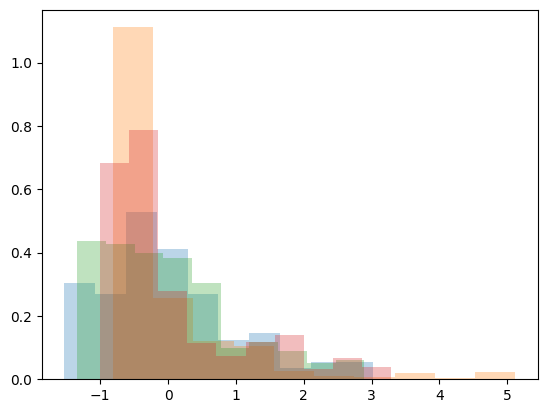

In [35]:
plt.figure()
plt.hist(ds.Y_test[:, 0], label='Test', alpha=0.3, density=True)
plt.hist(ds.Y_test[:, 1], label='Test', alpha=0.3, density=True)
plt.hist(ds.Y_test[:, 2], label='Test', alpha=0.3, density=True)
plt.hist(ds.Y_test[:, 3], label='Test', alpha=0.3, density=True)
# plt.hist(ds.Y_test[:, 3], label='Test', alpha=0.3, density=True)
# plt.hist(ds.Y_test[:, 4], label='Test', alpha=0.3, density=True)
# plt.hist(ds.Y_test[:, 5], label='Test', alpha=0.3, density=True)
# plt.hist(ds.Y_test[:, 6], label='Test', alpha=0.3, density=True)
# plt.hist(ds.Y_test[:, 7], label='Test', alpha=0.3, density=True)
# plt.hist(Y_test_sampled[:, 1], label='Samples for areas', alpha=0.3, density=True)
plt.show()


In [36]:
is_covered_sampled_51b = np.zeros(ds.n_test * n_samples)
quantiles_test_sampled = np.zeros((ds.n_test * n_samples, 4))
print(is_covered_sampled_51b.shape)
for i in tqdm(range(ds.n_test)):
    start = i * n_samples
    stop = (i + 1) * n_samples
    quantiles_test_sampled[start:stop] = \
        reg.predict_quantile(X_test_sampled[start:stop], Y_test_sampled[start:stop])
    is_covered_sampled_51b[start:stop] = \
        _get_coverage_otcp(quantiles_test_sampled[start:stop], mu, psi, threshold_51b, verbose=False)


is_covered_sampled_51a = np.linalg.norm(quantiles_test_sampled, axis=1) <= threshold_51a

is_covered_sampled_51a.shape, is_covered_sampled_51b.shape

(20000000,)


  0%|          | 0/2000 [00:00<?, ?it/s]

((20000000,), (20000000,))

In [37]:
import gc

reg.model.cpu()
_compute_batch_hessian = torch.vmap(func=hessian(reg.model.potential_network, argnums=1), 
                                   in_dims=0, chunk_size=8192)

log_det_hessians_test_samples = np.zeros(ds.n_test * n_samples)
for i in tqdm(range(ds.n_test // 8)):
    start = i * n_samples * 8
    stop = (i + 1) * n_samples * 8
    if i % 200 == 0:
        print(i, start, stop)

    _hessians = _compute_batch_hessian(
        torch.tensor(X_test_sampled[start:stop]),
        torch.tensor(Y_test_sampled[start:stop])
    )[:, 0].detach()

    log_det_hessians_test_samples[start:stop] = \
        torch.logdet(_hessians).squeeze().detach().numpy(force=True)

    if i > 0 and i % 100 == 0:
        gc.collect()
_ = reg.model.cpu()

  0%|          | 0/250 [00:00<?, ?it/s]

0 0 80000
200 16000000 16080000


In [38]:
print(f"{log_det_hessians_test_samples.shape=}")
log_f_u_test_samples = multivariate_normal.logpdf(quantiles_test_sampled, mean=np.zeros(4))
log_dets_test_sampled = log_det_hessians_test_samples
scores_test_sampled_52 = log_f_u_test_samples + log_dets_test_sampled
is_covered_sampled_52 = scores_test_sampled_52 >= threshold_52

log_det_hessians_test_samples.shape=(20000000,)


In [39]:
quantiles_test_sampled.shape, 

((20000000, 4),)

In [40]:
log_det_hessians_test_samples, log_f_u_test_samples

(array([-1.81278012,  1.79502358,  1.51841804, ...,  5.91516716,
         8.54516374,  2.55462944], shape=(20000000,)),
 array([-1862.88849726,  -477.44422085,  -290.67155989, ...,
         -567.4222261 ,   -67.60891262,   -62.35551337], shape=(20000000,)))

In [41]:
areas_51a, areas_51b, areas_52 = map(lambda t: t.reshape(ds.n_test, n_samples).mean(axis=-1) * scale, 
                                     (is_covered_sampled_51a, is_covered_sampled_51b, is_covered_sampled_52))

In [42]:
areas_52.mean()

np.float64(0.007426664808887994)

In [43]:
display(
    Markdown(
        r"#### Areas \n ${\mathrm{PB}}$:   " +
        f"**{areas_51a.mean():.2f}**,  " + 
        r"${\mathrm{RPB}}$:   " +
        f"**{areas_51b.mean():.2f}**,  " + 
        r"${\mathrm{HPD}}$:   " +
        f"**{areas_52.mean():.2f}**,  "
    )
)
3

#### Areas \n ${\mathrm{PB}}$:   **0.08**,  ${\mathrm{RPB}}$:   **0.11**,  ${\mathrm{HPD}}$:   **0.01**,  

3

In [44]:
(threshold_51a, threshold_51b, threshold_52)

(np.float64(2.619226844184662),
 np.float64(0.72102002002002),
 np.float64(2.908920581779195))

In [45]:
is_covered_sampled_52.mean(), is_covered_sampled_52.sum()

(np.float64(9.1e-06), np.int64(182))

In [46]:
is_covered_sampled_51a.mean(), is_covered_sampled_51a.sum()

(np.float64(0.0001001), np.int64(2002))

In [47]:
is_covered_sampled_51b.mean(), is_covered_sampled_51b.sum()

(np.float64(0.0001298), np.float64(2596.0))

In [48]:
0.4 ** 8

0.0006553600000000003

In [51]:
log_f_u_test_samples[:10], log_dets_test_sampled[:10]

(array([-2893.44431488, -2485.81517041, -1030.84263925, -2326.69791501,
        -3656.36555414, -3129.02225148, -1735.4873016 , -1040.89404477,
         -218.37331466, -1153.75148055]),
 array([5.76201264, 8.7472667 , 5.937831  , 5.32030896, 0.94985215,
        7.73581515, 2.67514361, 4.59827213, 8.4552727 , 6.3569224 ]))

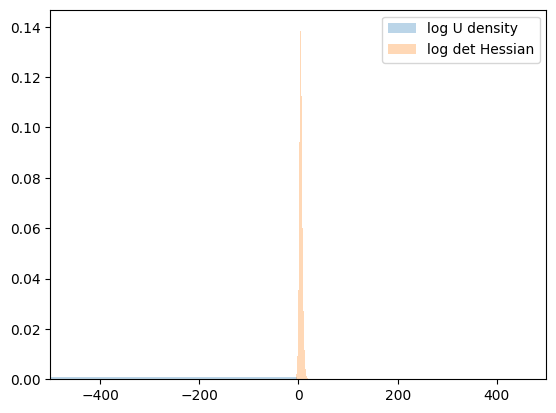

In [52]:
plt.figure()
plt.hist(log_f_u_test_samples, bins=500, density=True, alpha=0.3, label="log U density")
plt.hist(log_dets_test_sampled, bins=500, density=True, alpha=0.3, label="log det Hessian")
plt.xlim(-500, 500)
plt.legend()
plt.show()

In [53]:
scale

np.float64(816.1170119657136)

In [54]:
areas_51b

array([0.       , 0.       , 0.       , ..., 0.0816117, 0.       ,
       0.       ], shape=(2000,))

In [55]:
is_covered_sampled_51a.mean(), is_covered_sampled_51b.mean(), is_covered_sampled_52.mean()

(np.float64(5.65e-05), np.float64(7.395e-05), np.float64(1.27e-05))